# Rotation matrix for spherical harmonics

#### Code to compute and validate the rotation matrix for spherical harmonics

We begin by importing some stuff and defining our functions:

In [37]:
import numpy as np
from IPython.display import display, Math
import sympy
from sympy import *
from sympy.functions.special.tensor_functions import KroneckerDelta
import starry
import matplotlib
%matplotlib inline

# Initialize the session
init_session(quiet=True)

# I am using the dev version of sympy
print("Using sympy version", sympy.__version__)

# Define our symbols
l, m, n, alpha, beta, gamma, u1, u2, u3, theta = symbols('l m n alpha beta gamma u1 u2 u3 theta')


Using sympy version 1.1.2.dev


In [2]:
def Dmn(l, m, n, alpha, beta, gamma):
    """Compute the (m, n) term of the Wigner D matrix."""
    sumterm = 0
    # Expression diverges when beta = 0
    if beta == 0:
        beta = 1e-16
    for k in range(l + m + 1):
        sumterm += (-1) ** k * cos(beta / 2) ** (2 * l + m - n - 2 * k) * \
                   sin(beta / 2) ** (-m + n + 2 * k) / \
                   (factorial(k) * factorial(l + m - k) * factorial(l - n - k) * factorial(n - m + k))
    return sumterm * exp(-I * (alpha * n + gamma * m)) * (-1) ** (n + m) * \
           sqrt(factorial(l - m) * factorial(l + m) * factorial(l - n) * factorial(l + n))

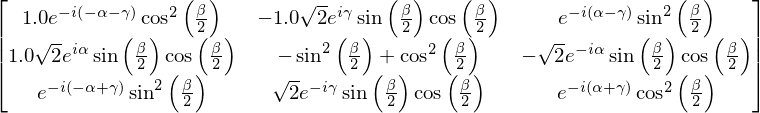

In [3]:
def D(l, alpha, beta, gamma):
    """Compute the Wigner D matrix."""
    res = zeros(2 * l + 1, 2 * l + 1)
    for m in range(-l, l + 1):
        for n in range(-l, l + 1):
            res[m + l, n + l] = Dmn(l, m, n, alpha, beta, gamma)
    return res

# Print it for l = 1
D(1, alpha, beta, gamma)

In [4]:
def Umn(l, m, n):
    """Compute the (m, n) term of the transformation matrix from complex to real Ylms."""
    if n < 0:
        term1 = I
    elif n == 0:
        term1 = sqrt(2) / 2
    else:
        term1 = 1
    if (m > 0) and (n < 0) and (n % 2 == 0):
        term2 = -1
    elif (m > 0) and (n > 0) and (n % 2 != 0):
        term2 = -1
    else:
        term2 = 1
    return term1 * term2 * 1 / sqrt(2) * (KroneckerDelta(m, n) + KroneckerDelta(m, -n))

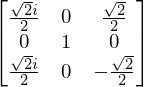

In [5]:
def U(l):
    """Compute the U transformation matrix."""
    res = zeros(2 * l + 1, 2 * l + 1)
    for m in range(-l, l + 1):
        for n in range(-l, l + 1):
            res[m + l, n+ l] = Umn(l, m, n)
    return res

# Print it for l = 1
U(1)

In [6]:
def REuler(l, alpha, beta, gamma):
    """Return the rotation matrix for a single degree `l`."""
    res = zeros(2 * l + 1, 2 * l + 1)
    if l == 0:
        res[0, 0] = 1
        return res
    foo = re(U(l).inv() * D(l, alpha, beta, gamma) * U(l))
    for m in range(2 * l + 1):
        for n in range(2 * l + 1):
            if abs(foo[m, n]) < 1e-15:
                res[m, n] = 0
            else:
                res[m, n] = foo[m, n]
    return res

To make things easier to visualize, let's convert our rotation matrix to the axis-angle formalism.

In [174]:
def RAxisAngle(l, u1, u2, u3, theta):
    """Axis-angle rotation matrix."""
    # Numerical tolerance
    tol = 1e-16
    if theta == 0:
        theta = tol
    if u1 == 0 and u2 == 0:
        u1 = tol
        u2 = tol
        
    # Elements of the transformation matrix
    costheta = cos(theta)
    sintheta = sin(theta)
    RA01 = u1 * u2 * (1 - costheta) - u3 * sintheta
    RA02 = u1 * u3 * (1 - costheta) + u2 * sintheta
    RA11 = costheta + u2 * u2 * (1 - costheta)
    RA12 = u2 * u3 * (1 - costheta) - u1 * sintheta
    RA20 = u3 * u1 * (1 - costheta) - u2 * sintheta
    RA21 = u3 * u2 * (1 - costheta) + u1 * sintheta
    RA22 = costheta + u3 * u3 * (1 - costheta)

    # Determine the Euler angles
    if ((RA22 < -1 + tol) and (RA22 > -1 - tol)):
        cosbeta = -1
        sinbeta = 0
        cosgamma = RA11
        singamma = RA01
        cosalpha = 1
        sinalpha = 0
    elif ((RA22 < 1 + tol) and (RA22 > 1 - tol)):
        cosbeta = 1
        sinbeta = 0
        cosgamma = RA11
        singamma = -RA01
        cosalpha = 1
        sinalpha = 0
    else:
        cosbeta = RA22
        sinbeta = sqrt(1 - cosbeta ** 2)
        norm1 = sqrt(RA20 * RA20 + RA21 * RA21)
        norm2 = sqrt(RA02 * RA02 + RA12 * RA12)
        cosgamma = -RA20 / norm1
        singamma = RA21 / norm1
        cosalpha = RA02 / norm2
        sinalpha = RA12 / norm2
    alpha = atan2(sinalpha, cosalpha)
    beta = atan2(sinbeta, cosbeta)
    gamma = atan2(singamma, cosgamma)
    
    return REuler(l, alpha, beta, gamma)

Finally, note that `RAxisAngle` is the rotation matrix for a single degree `l`. To get the full rotation matrix, we construct it as a block diagonal matrix with the matrices for each `l` along the diagonal: 

In [134]:
def R(lmax, u1, u2, u3, theta):
    """Return the full axis-angle rotation matrix up to degree `lmax`."""
    blocks = [RAxisAngle(l, u1, u2, u3, theta) for l in range(lmax + 1)]
    return BlockDiagMatrix(*blocks)

And just for fun, let's define a rotation function to operate on actual `starry` spherical harmonic maps:

In [161]:
def rotate(map, u, theta):
    """Rotate a starry spherical harmonic map `y` using the rotation matrix defined above."""
    y = Matrix(map.y)
    yrot = Matrix(R(map.lmax, u[0], u[1], u[2], theta)) * y
    map[:] = np.array(yrot[:])

### Let's test some rotations!

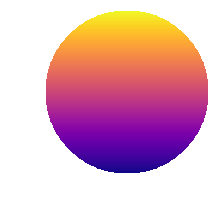

In [175]:
map = starry.Map(1)
map[1, -1] = 1
map.show()

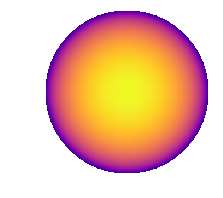

In [176]:
# Rotate 90 degrees counter-clockwise about xhat
rotate(map, [1, 0, 0], np.pi / 2)
map.show()

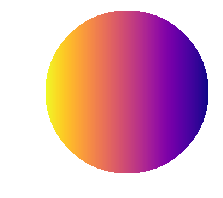

In [177]:
# Rotate 90 degrees counter-clockwise about yhat
rotate(map, [0, 1, 0], np.pi / 2)
map.show()

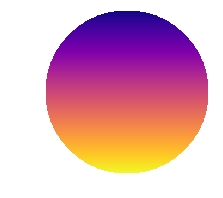

In [178]:
# Rotate 90 degrees counter-clockwise about zhat
rotate(map, [0, 0, 1], np.pi / 2)
map.show()

■